In [7]:
import obspy
import matplotlib.pyplot as plt
import numpy as np
import math

from scipy.signal import butter, filtfilt

import os

# b-end

In [3]:
# Normalizing amplitude response for all component
def normamp(z, n, e):
    templis = []
    data = []
    templis.append(z.data), templis.append(n.data), templis.append(e.data)

    for x in range(len(templis)):
        for y in range(len(templis[x])):
            data.append(templis[x][y])
    
    xmin = min(data)
    xmax = max(data)
    
    Z = 2*((z-xmin)/(xmax-xmin))-1
    N = 2*((n-xmin)/(xmax-xmin))-1
    E = 2*((e-xmin)/(xmax-xmin))-1
    return Z, N, E

# Apply Bandpass Butterworth and Zero Phase filter to a time series
def bpzphase(normalizedamp, lc=1, hc=3.7, fs=100, order=5):
    fnyq = 0.5*fs
    
    # Create the filter coefficients
    b, a = butter(order,[lc/fnyq, hc/fnyq], btype='bandpass')
    # Apply the filter to your signal (replace 'signal' with your actual data)
    filt = filtfilt(b, a, normalizedamp, padlen=3*(max(len(b), len(a))-1))
    return filt

# Splitting the data
def split(filteredsignal, comp, windowlength, d=0.5, overlap=True):
    overlapp = overlap
    if overlapp == False:
        return np.split(filteredsignal, comp.stats.npts/(windowlength*comp.stats.sampling_rate))
    else:
        w = []
        for i in range(0, len(filteredsignal), round(windowlength*comp.stats.sampling_rate*(1-d))):
            w.append(filteredsignal[i:i+int(windowlength*comp.stats.sampling_rate)])
        while len(w[-1]) != windowlength*comp.stats.sampling_rate:
            del w[-1]
        return w

# Merging the splitted per component to one variable, to find the covariance matrix 
def merge(Z, N, E):
    zerolist = np.zeros((3, len(Z)), dtype=np.float64)
    # East
    zerolist[0] = E
    # North
    zerolist[1] = N
    # Z
    zerolist[2] = Z
    return zerolist

# Performing Polarization Analysis (Referring to Saenger et al., 2009) 
def polarization(sdZ, sdN, sdE):
    azilist, incilist, rectlist, planlist, maxeigvlist = [], [], [], [], []
    
    for i in range(len(sdZ)):
        merged = merge(sdZ[i], sdN[i], sdE[i])
        covmat = np.cov(merged)
        eigvec, eigenval, v = np.linalg.svd(covmat)
        
        # Rectilinearity defined after Montalbetti & Kanasewich, 1970
        rect = 1.0 - np.sqrt(eigenval[1] / eigenval[0])
        
        # Planarity defined after [Jurkevics1988]_
        plan = 1.0 - (2.0 * eigenval[2] / (eigenval[1] + eigenval[0]))

        # Azimuth
        azimuth = math.degrees(math.atan2(eigvec[0][0], eigvec[1][0]))

        # Incidence
        eve = np.sqrt(eigvec[0][0] ** 2 + eigvec[1][0] ** 2)
        incidence = math.degrees(math.atan2(eve, eigvec[2][0]))

        # Max Eigenvalue
        maxeigenval = max(eigenval)
        
        if azimuth < 0.0:
            azimuth = 360.0 + azimuth
        if incidence < 0.0:
            incidence += 180.0
        if incidence > 90.0:
            incidence = 180.0 - incidence
            if azimuth > 180.0:
                azimuth -= 180.0
            else:
                azimuth += 180.0
        incidence = 90 - abs(incidence)

        azilist.append(azimuth), incilist.append(incidence), rectlist.append(rect), planlist.append(plan), maxeigvlist.append(maxeigenval)
    
    return azilist, incilist, rectlist, planlist, maxeigvlist

# Plot Polarization Analysis Alternate

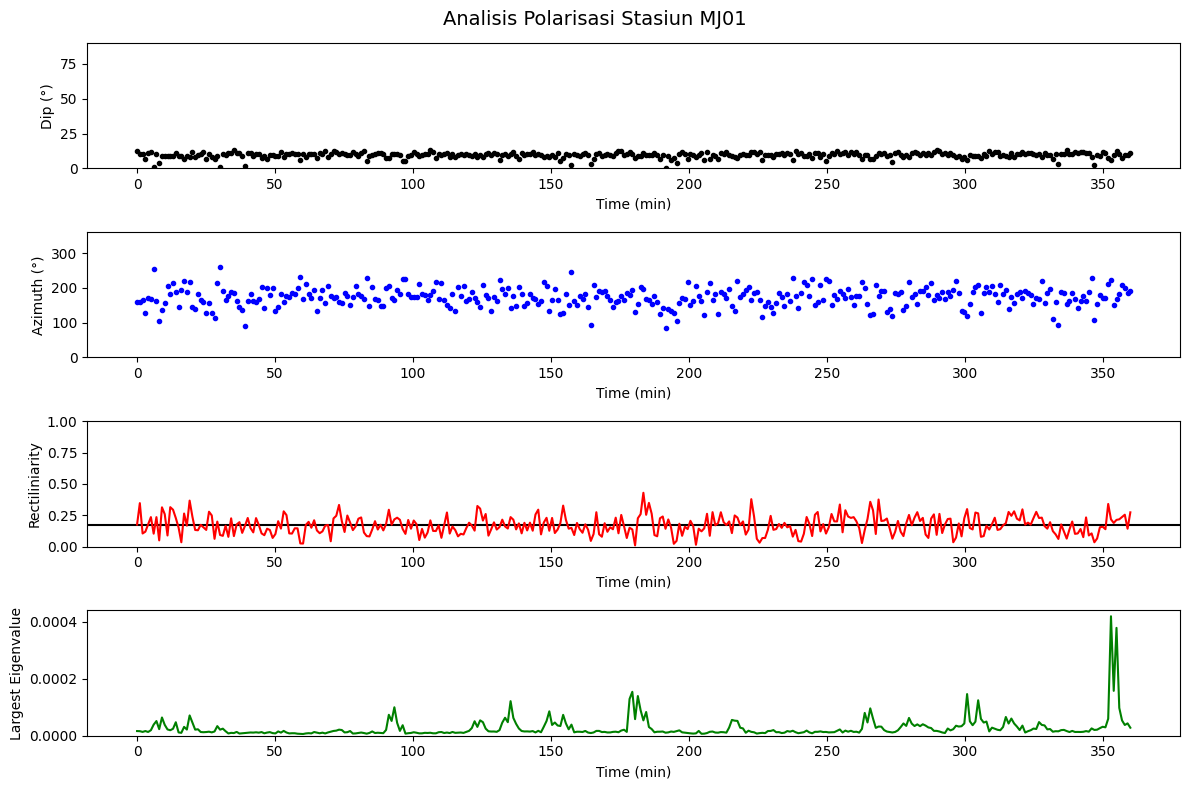

In [4]:
'''
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(12, 8))

ax1.plot(time, inc, ".k")
ax1.set_xlabel("Time (min)")
ax1.set_ylabel("Dip (°)")
ax1.set_ylim((0, 90))

ax2.plot(time, az, ".b")
ax2.set_xlabel("Time (min)")
ax2.set_ylabel("Azimuth (°)")
ax2.set_ylim((0, 360))

ax3.axhline(np.sum(rec)/len(rec), color="k")
ax3.plot(time, rec, "-r")
ax3.set_xlabel("Time (min)")
ax3.set_ylabel("Rectiliniarity")
ax3.set_ylim((0, 1))

ax4.plot(time, maxeigv, "-g")
ax4.set_xlabel("Time (min)")
ax4.set_ylabel("Largest Eigenvalue")
ax4.set_ylim(0)

fig.suptitle("Analisis Polarisasi Stasiun MJ{}".format(Z.stats.station), fontsize = 14)
fig.tight_layout()
plt.show()
'''

# Plot Polarization Analysis

In [12]:
directory = 'C:/Users/PC-MSI/Downloads/RawDataSkripsi2'

for filename in os.listdir(directory):
    if filename.endswith('.mseed'):
        traces = obspy.read("C:/Users/PC-MSI/Downloads/RawDataSkripsi2/{}".format(filename), format="MSEED")

        Z = traces[0]
        N = traces[1]
        E = traces[2]

        window_length = 60 #in seconds

        # Pre-Processing
        Znorm, Nnorm, Enorm = normamp(Z, N, E)
        filtZ, filtN, filtE = bpzphase(Znorm), bpzphase(Nnorm), bpzphase(Enorm)

        # Processing - Polarization Analysis
        sdZ, sdN, sdE = split(filtZ, Z, window_length), split(filtN, N, window_length), split(filtE, E, window_length)
        az, inc, rec, plan, maxeigv = polarization(sdZ, sdN, sdE)

        # Making x for plotting
        time = np.linspace(0, 360, 360)

        # Plotting
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

        ax1.plot(time, inc, ".k")
        ax1.set_xlabel("Time (min)")
        ax1.set_ylabel("Dip (°)")
        ax1.set_ylim((0, 90))

        ax2.plot(time, az, ".b")
        ax2.set_xlabel("Time (min)")
        ax2.set_ylabel("Azimuth (°)")
        ax2.set_ylim((0, 360))

        ax3.axhline(np.sum(rec)/len(rec), color="k")
        ax3.plot(time, rec, "-r")
        ax3.set_xlabel("Time (min)")
        ax3.set_ylabel("Rectiliniarity")
        ax3.set_ylim((0, 1))

        ax4.plot(time, maxeigv, "-g")
        ax4.set_xlabel("Time (min)")
        ax4.set_ylabel("Largest Eigenvalue")
        ax4.set_ylim(0)

        fig.suptitle("Analisis Polarisasi Stasiun MJ{}".format(Z.stats.station), fontsize = 14)
        fig.tight_layout()

        plt.savefig("Stasiun MJ{}-Analisis Polarisasi.png".format(Z.stats.station))
        plt.close()
        #plt.show()